1. Import libraries

In [1]:
import os, json, math, pathlib
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)
import joblib

2. Plot style

In [2]:
sns.set_context("talk")
sns.set_style("whitegrid")

RANDOM_STATE = 42

3. Directories

In [3]:
DATA_DIR      = Path("../data/processed")
REPORTS_DIR   = Path("../reports")
FIG_DIR       = REPORTS_DIR / "figures"
ARTIFACTS_DIR = Path("../artifacts")
MODELS_DIR    = Path("../models")

for p in (REPORTS_DIR, FIG_DIR):
    p.mkdir(parents=True, exist_ok=True)

4. Inputs (tables produced in NB3)

In [4]:
MODEL_TABLE_STRICT   = DATA_DIR / "model_strict.csv"
MODEL_TABLE_COMBINED = DATA_DIR / "model_combined.csv"

5. Saved pipelines (NB5 & NB6)

In [5]:
REG_PIPE_PATH = MODELS_DIR / "tuned_randomforest_pipeline.joblib"   # regression
CLS_PIPE_PATH = MODELS_DIR / "clf_randomforest_tuned.joblib"           # classification

6. Output report files

In [6]:
SUMMARY_MD   = REPORTS_DIR / "summary.md"
METRICS_CSV  = REPORTS_DIR / "metrics_summary.csv"

7. Helper functions (metrics & plotting)

In [7]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def print_kv(d):
    for k, v in d.items():
        if isinstance(v, float):
            print(f"{k}: {v:.3f}")
        else:
            print(f"{k}: {v}")

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=180, bbox_inches="tight")
    print(f"[fig] {path}")

def split_tvtest(df, target, test_size=0.30, valid_share=0.50, seed=RANDOM_STATE):
    """70/15/15 split (train/valid/test) by default."""
    X = df.drop(columns=[target])
    y = df[target].astype(float)
    X_tr, X_temp, y_tr, y_temp = train_test_split(X, y, test_size=test_size, random_state=seed)
    X_va, X_te, y_va, y_te     = train_test_split(X_temp, y_temp, test_size=valid_share, random_state=seed)
    return X_tr, X_va, X_te, y_tr, y_va, y_te

8. Load models tables & quick data KPIs

In [8]:
strict = pd.read_csv(MODEL_TABLE_STRICT)
combined = pd.read_csv(MODEL_TABLE_COMBINED)

print("strict shape:", strict.shape)
print("combined shape:", combined.shape)

# Classification target (if present already)
is_high_present = "is_high" in strict.columns
class_balance = None
if is_high_present:
    class_balance = strict["is_high"].value_counts(normalize=True).rename("pct").mul(100).round(2)
    print("\nClass balance (strict, %):")
    display(class_balance)

# Save tiny overview as CSV
kpis = pd.DataFrame({
    "dataset":["strict","combined"],
    "rows":[len(strict), len(combined)],
    "cols":[strict.shape[1], combined.shape[1]],
})
kpis.to_csv(REPORTS_DIR / "dataset_overview.csv", index=False)
kpis

strict shape: (3067, 37)
combined shape: (5267, 38)

Class balance (strict, %):


is_high
0    64.53
1    35.47
Name: pct, dtype: float64

,dataset,rows,cols
0,strict,3067,37
1,combined,5267,38


9. Regression report (if pipeline exists)

→ Running regression report from: tuned_randomforest_pipeline.joblib

[Regression | Test metrics]
task: regression
MAE: 0.750
RMSE: 0.975
R2: 0.260
[fig] ../reports/figures/reg_pred_vs_actual.png


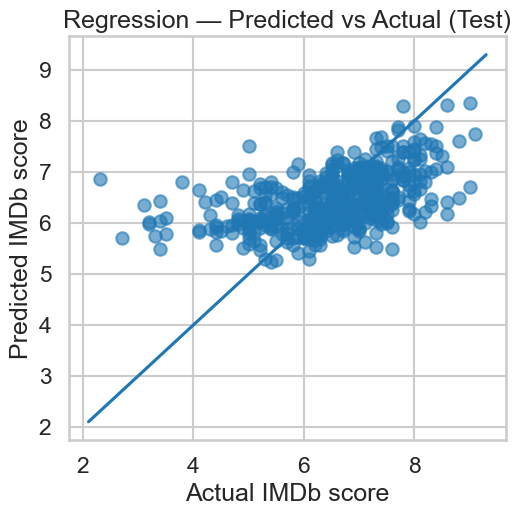

[fig] ../reports/figures/reg_residuals_hist.png


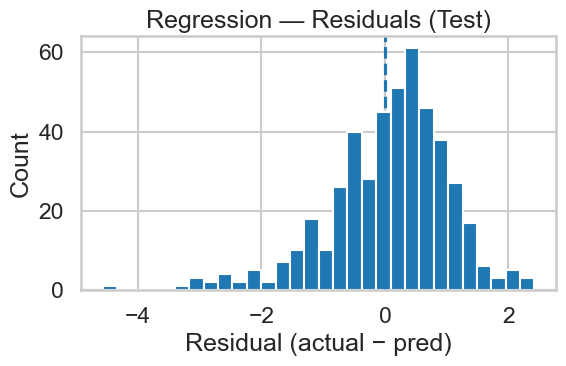

In [9]:
if REG_PIPE_PATH.exists():
    print("→ Running regression report from:", REG_PIPE_PATH.name)
    reg_pipe = joblib.load(REG_PIPE_PATH)

    # Build regression table from STRICT model table (Notebook 5 used strict)
    # Target = imdb_score; drop helper columns if present
    df_reg = strict.copy()
    target = "imdb_score"
    drop_if_exists = {"title", "id", "imdb_id", "description", "is_high"}
    df_reg = df_reg.drop(columns=[c for c in drop_if_exists if c in df_reg.columns])

    X_tr, X_va, X_te, y_tr, y_va, y_te = split_tvtest(df_reg, target)

    # Eval on test
    y_pred = reg_pipe.predict(X_te)
    reg_metrics = {
        "task": "regression",
        "MAE": mean_absolute_error(y_te, y_pred),
        "RMSE": rmse(y_te, y_pred),
        "R2": r2_score(y_te, y_pred)
    }
    print("\n[Regression | Test metrics]")
    print_kv(reg_metrics)

    # Plots
    # 1) Predicted vs Actual
    plt.figure(figsize=(5.5,5.5))
    plt.scatter(y_te, y_pred, alpha=0.6)
    lims = [min(y_te.min(), y_pred.min())-0.2, max(y_te.max(), y_pred.max())+0.2]
    plt.plot(lims, lims)
    plt.xlabel("Actual IMDb score")
    plt.ylabel("Predicted IMDb score")
    plt.title("Regression — Predicted vs Actual (Test)")
    savefig(FIG_DIR / "reg_pred_vs_actual.png")
    plt.show()

    # 2) Residuals histogram
    resid = y_te - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(resid, bins=30)
    plt.axvline(0, linestyle="--")
    plt.xlabel("Residual (actual − pred)")
    plt.ylabel("Count")
    plt.title("Regression — Residuals (Test)")
    savefig(FIG_DIR / "reg_residuals_hist.png")
    plt.show()
else:
    print("… regression pipeline not found, skipping regression report.")
    reg_metrics = None

10. Classification Report (if pipeline exists)


→ Running classification report from: clf_randomforest_tuned.joblib

[Classification | Test metrics]
task: classification
Accuracy: 0.772
Precision: 0.845
Recall: 0.514
F1: 0.639
ROC_AUC: 0.897
PR_AUC: 0.855
[fig] ../reports/figures/cls_confusion_matrix.png


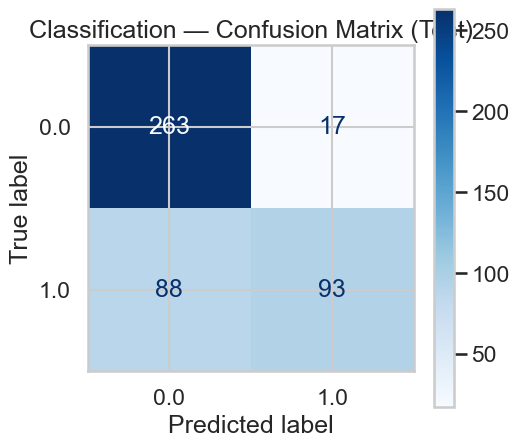

[fig] ../reports/figures/cls_roc.png


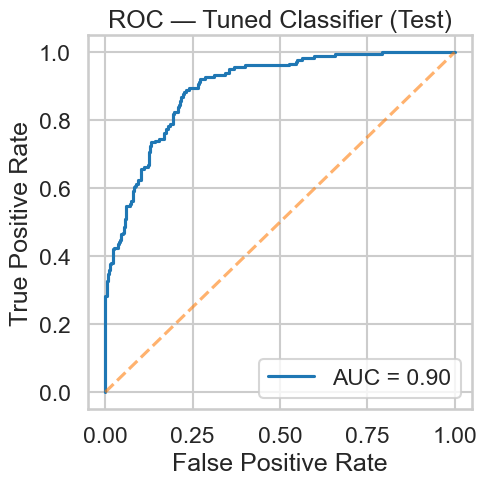

[fig] ../reports/figures/cls_pr.png


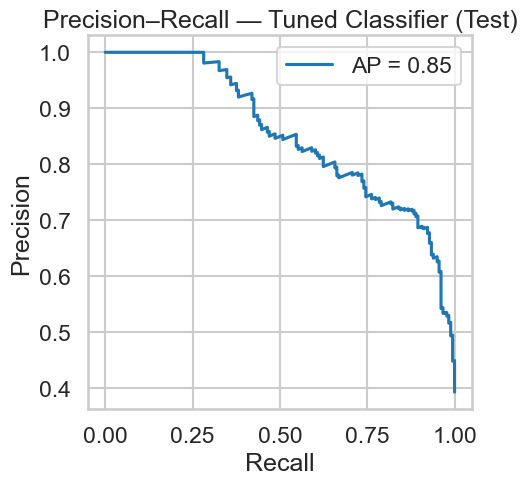

In [10]:
if CLS_PIPE_PATH.exists():
    print("\n→ Running classification report from:", CLS_PIPE_PATH.name)
    cls_pipe = joblib.load(CLS_PIPE_PATH)

    df_cls = strict.copy()
    assert "is_high" in df_cls.columns, "is_high target not found in strict model table."
    target = "is_high"
    drop_if_exists = {"title", "id", "imdb_id", "description", "imdb_score"}
    df_cls = df_cls.drop(columns=[c for c in drop_if_exists if c in df_cls.columns])

    X_tr, X_va, X_te, y_tr, y_va, y_te = split_tvtest(df_cls, target)

    # Predict on test
    y_prob = cls_pipe.predict_proba(X_te)[:,1]
    y_pred = (y_prob >= 0.5).astype(int)

    cls_metrics = {
        "task": "classification",
        "Accuracy": accuracy_score(y_te, y_pred),
        "Precision": precision_score(y_te, y_pred),
        "Recall": recall_score(y_te, y_pred),
        "F1": f1_score(y_te, y_pred),
        "ROC_AUC": roc_auc_score(y_te, y_prob),
        "PR_AUC": average_precision_score(y_te, y_prob)
    }
    print("\n[Classification | Test metrics]")
    print_kv(cls_metrics)

    # Confusion matrix
    fig, ax = plt.subplots(figsize=(5.5,5))
    ConfusionMatrixDisplay.from_predictions(y_te, y_pred, ax=ax, cmap="Blues")
    ax.set_title("Classification — Confusion Matrix (Test)")
    savefig(FIG_DIR / "cls_confusion_matrix.png")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_te, y_prob)
    plt.figure(figsize=(5.2,5.2))
    plt.plot(fpr, tpr, label=f"AUC = {cls_metrics['ROC_AUC']:.2f}")
    plt.plot([0,1],[0,1],'--', alpha=0.6)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC — Tuned Classifier (Test)")
    plt.legend()
    savefig(FIG_DIR / "cls_roc.png")
    plt.show()

    # Precision-Recall curve
    prec, rec, _ = precision_recall_curve(y_te, y_prob)
    plt.figure(figsize=(5.2,5.2))
    plt.plot(rec, prec, label=f"AP = {cls_metrics['PR_AUC']:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall — Tuned Classifier (Test)")
    plt.legend()
    savefig(FIG_DIR / "cls_pr.png")
    plt.show()
else:
    print("… classification pipeline not found, skipping classification report.")
    cls_metrics = None

11. Consolidated metrics table + lightweight "Model Card"

In [11]:
rows = []
if reg_metrics is not None:
    rows.append({"Task":"Regression", **{k:v for k,v in reg_metrics.items() if k!='task'}})
if cls_metrics is not None:
    rows.append({"Task":"Classification", **{k:v for k,v in cls_metrics.items() if k!='task'}})

metrics_df = pd.DataFrame(rows)
display(metrics_df)
metrics_df.to_csv(METRICS_CSV, index=False)
print(f"[table] {METRICS_CSV}")

# --- Model Card (summary.md) ---
lines = []
lines.append("# Netflix IMDb Project — Reporting Summary\n")
lines.append("## Datasets\n")
lines.append(f"- **Strict table**: `{MODEL_TABLE_STRICT.name}` — {len(strict)} rows, {strict.shape[1]} cols.")
lines.append(f"- **Combined table**: `{MODEL_TABLE_COMBINED.name}` — {len(combined)} rows, {combined.shape[1]} cols.\n")

if reg_metrics is not None:
    lines.append("## Regression (IMDb score prediction)\n")
    lines.append(f"- **Pipeline**: `{REG_PIPE_PATH.name}`  \n"
                 f"- **Test MAE**: {reg_metrics['MAE']:.3f}  \n"
                 f"- **Test RMSE**: {reg_metrics['RMSE']:.3f}  \n"
                 f"- **Test R²**: {reg_metrics['R2']:.3f}\n")
    lines.append("**Figures**  \n"
                 f"- Pred vs Actual: `reports/figures/reg_pred_vs_actual.png`  \n"
                 f"- Residuals: `reports/figures/reg_residuals_hist.png`\n")

if cls_metrics is not None:
    lines.append("## Classification (High vs Not-High)\n")
    lines.append(f"- **Pipeline**: `{CLS_PIPE_PATH.name}`  \n"
                 f"- **Test Accuracy**: {cls_metrics['Accuracy']:.3f}  \n"
                 f"- **Precision**: {cls_metrics['Precision']:.3f}  \n"
                 f"- **Recall**: {cls_metrics['Recall']:.3f}  \n"
                 f"- **F1**: {cls_metrics['F1']:.3f}  \n"
                 f"- **ROC-AUC**: {cls_metrics['ROC_AUC']:.3f}  \n"
                 f"- **PR-AUC**: {cls_metrics['PR_AUC']:.3f}\n")
    lines.append("**Figures**  \n"
                 f"- Confusion Matrix: `reports/figures/cls_confusion_matrix.png`  \n"
                 f"- ROC: `reports/figures/cls_roc.png`  \n"
                 f"- PR: `reports/figures/cls_pr.png`\n")

lines.append("## Notes & Caveats\n")
lines.append("- Votes (log and raw), duration, and release year are consistently among the strongest predictors.\n"
             "- Classification favors precision at the default 0.5 threshold. Tune the threshold for higher recall if needed.\n"
             "- Country/age categories have small standalone effects; use with caution to avoid spurious conclusions.\n")

SUMMARY_MD.write_text("\n".join(lines), encoding="utf-8")
print(f"[doc] {SUMMARY_MD}")

,Task,MAE,RMSE,R2,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC
0,Regression,0.749601,0.974608,0.259656,NaN,NaN,NaN,NaN,NaN,NaN
1,Classification,NaN,NaN,NaN,0.772234,0.845455,0.513812,0.639175,0.896882,0.854517


[table] ../reports/metrics_summary.csv
[doc] ../reports/summary.md


12. Permutation importance plots for both regression and classification models

Shapes — regression: (2146, 35) (460, 35) (461, 35)
Shapes — classification: (2146, 34) (460, 34) (461, 34)
Loaded regression pipe: True | classification pipe: True
[Regression] Test RMSE: 0.975


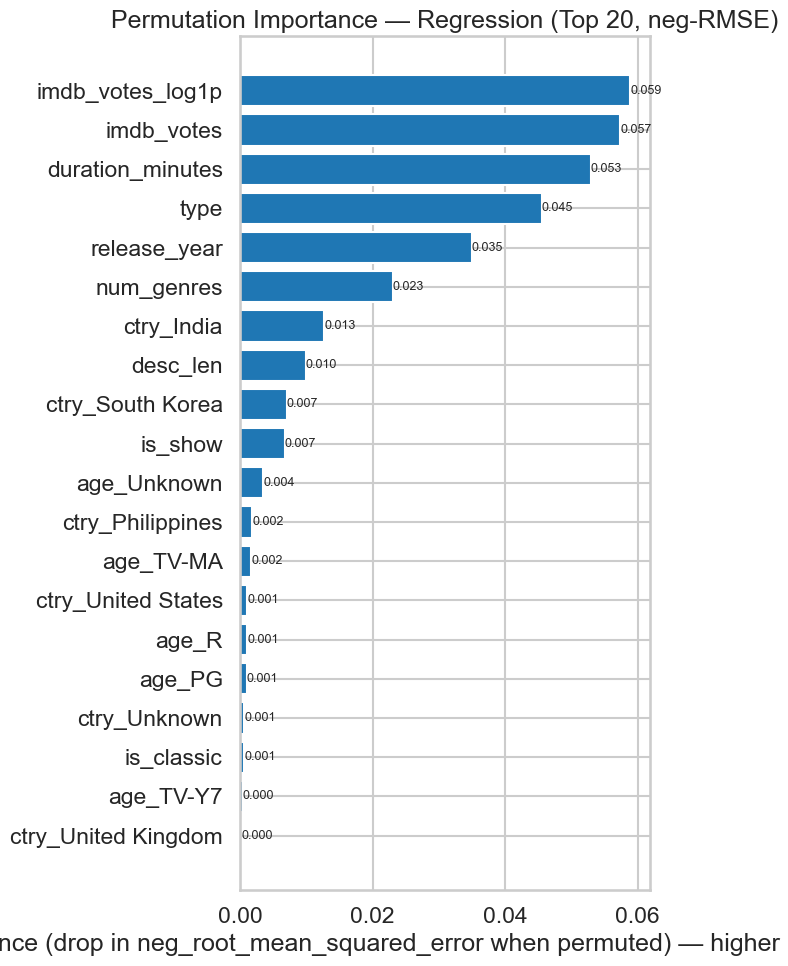

[saved] ../reports/figures/perm_importance_reg.png
[saved] ../reports/perm_importance_regression.csv
[Classification] Test ROC-AUC: 0.790


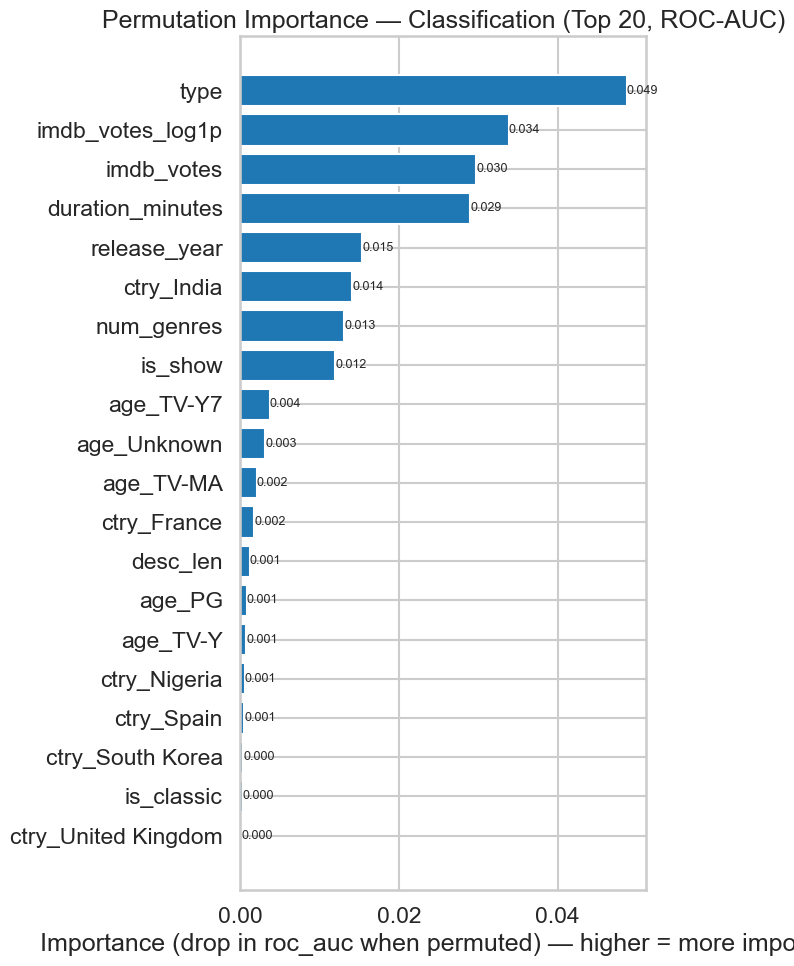

[saved] ../reports/figures/perm_importance_cls.png
[saved] ../reports/perm_importance_classification.csv


In [12]:
# --- Bootstrap after kernel restart: rebuild splits, load pipes, run & save permutation importance ---

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.inspection import permutation_importance
import joblib

RANDOM_STATE = 42
BASE = Path("..")
DATA = BASE / "data" / "processed"
MODELS = BASE / "models"
REPORTS = BASE / "reports"
FIGS = REPORTS / "figures"
FIGS.mkdir(parents=True, exist_ok=True)

# ---- Load model tables
df_strict = pd.read_csv(DATA / "model_strict.csv")

# ---- Targets
TARGET_REG = "imdb_score"
if "is_high" in df_strict.columns:
    TARGET_CLS = "is_high"
else:
    TARGET_CLS = "is_high"
    df_strict[TARGET_CLS] = (df_strict["imdb_score"] >= 7.0).astype(int)

# ---- Common feature prep (drop obvious non-features)
drop_if_exists = {"title","id","imdb_id","description"}

# --------- Build regression splits
reg_df = df_strict.drop(columns=[c for c in drop_if_exists if c in df_strict.columns])
X_reg = reg_df.drop(columns=[TARGET_REG])
y_reg = reg_df[TARGET_REG].astype(float)

Xtr_reg, Xtmp_reg, ytr_reg, ytmp_reg = train_test_split(
    X_reg, y_reg, test_size=0.30, random_state=RANDOM_STATE
)
Xva_reg, Xte_reg, yva_reg, yte_reg = train_test_split(
    Xtmp_reg, ytmp_reg, test_size=0.50, random_state=RANDOM_STATE
)

# --------- Build classification splits
cls_df = df_strict.drop(columns=[c for c in drop_if_exists if c in df_strict.columns])
X_cls = cls_df.drop(columns=[TARGET_CLS, TARGET_REG], errors="ignore")
y_cls = cls_df[TARGET_CLS].astype(int)

Xtr_clf, Xtmp_clf, ytr_clf, ytmp_clf = train_test_split(
    X_cls, y_cls, test_size=0.30, random_state=RANDOM_STATE, stratify=y_cls
)
Xva_clf, Xte_clf, yva_clf, yte_clf = train_test_split(
    Xtmp_clf, ytmp_clf, test_size=0.50, random_state=RANDOM_STATE, stratify=ytmp_clf
)

print("Shapes — regression:", Xtr_reg.shape, Xva_reg.shape, Xte_reg.shape)
print("Shapes — classification:", Xtr_clf.shape, Xva_clf.shape, Xte_clf.shape)

# ---- Load saved pipelines
reg_path = MODELS / "tuned_randomforest_pipeline.joblib"
clf_path = MODELS / "clf_randomforest_tuned.joblib"
reg_pipe = joblib.load(reg_path) if reg_path.exists() else None
clf_pipe = joblib.load(clf_path) if clf_path.exists() else None
print(f"Loaded regression pipe: {bool(reg_pipe)} | classification pipe: {bool(clf_pipe)}")

# ---- Helper: permutation importance on INPUT columns (robust to pipelines)
def perm_imp_on_inputs(pipe, X, y, scoring, title, out_png, top_k=20, repeats=20, random_state=42):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    perm = permutation_importance(
        estimator=pipe, X=X, y=y,
        n_repeats=repeats, random_state=random_state,
        scoring=scoring
    )
    feat_names = np.array(X.columns)
    imp_df = (pd.DataFrame({
        "feature": feat_names,
        "perm_importance_mean": perm.importances_mean,
        "perm_importance_std":  perm.importances_std
    }).sort_values("perm_importance_mean", ascending=False)
      .reset_index(drop=True))

    # Plot & save
    top = imp_df.head(top_k).iloc[::-1]
    plt.figure(figsize=(7,10))
    plt.barh(top["feature"], top["perm_importance_mean"])
    for i, v in enumerate(top["perm_importance_mean"]):
        plt.text(v, i, f"{v:.3f}", va="center", ha="left", fontsize=9)
    plt.xlabel(f"Importance (drop in {scoring} when permuted) — higher = more important")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()
    return imp_df

# ---- Run & save: Regression
if reg_pipe is not None:
    yhat = reg_pipe.predict(Xte_reg)
    rmse = float(np.sqrt(mean_squared_error(yte_reg, yhat)))
    print(f"[Regression] Test RMSE: {rmse:.3f}")
    reg_imp = perm_imp_on_inputs(
        reg_pipe, Xte_reg, yte_reg,
        scoring="neg_root_mean_squared_error",
        title="Permutation Importance — Regression (Top 20, neg-RMSE)",
        out_png=str(FIGS / "perm_importance_reg.png")
    )
    reg_imp.to_csv(REPORTS / "perm_importance_regression.csv", index=False)
    print("[saved]", FIGS / "perm_importance_reg.png")
    print("[saved]", REPORTS / "perm_importance_regression.csv")

# ---- Run & save: Classification
if clf_pipe is not None:
    prob = clf_pipe.predict_proba(Xte_clf)[:,1]
    auc = float(roc_auc_score(yte_clf, prob))
    print(f"[Classification] Test ROC-AUC: {auc:.3f}")
    clf_imp = perm_imp_on_inputs(
        clf_pipe, Xte_clf, yte_clf,
        scoring="roc_auc",
        title="Permutation Importance — Classification (Top 20, ROC-AUC)",
        out_png=str(FIGS / "perm_importance_cls.png")
    )
    clf_imp.to_csv(REPORTS / "perm_importance_classification.csv", index=False)
    print("[saved]", FIGS / "perm_importance_cls.png")
    print("[saved]", REPORTS / "perm_importance_classification.csv")